# The pathways and fate of existing plastic pollution along Greek coastlines
In this example, we will use `plasticparcels` to run a basic simulation of microplastic pollution along the Greek coastline. We will use the [Current global ocean plastic concentrations dataset](https://plastic.oceanparcels.org/en/latest/initialisationmaps.html) to release virtual particles in coastal model grid cells, using the 2D surface velocity fields to advect the particles. We also include the effects of Stokes drift and wind-induced drift on the particles, but neglect any vertical motion (along with any biofouling, or vertical mixing).

In [1]:
# Library imports
from datetime import datetime, timedelta

# parcels and plasticparcels imports
import plasticparcels as pp

# Plotting imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

## Load settings
We first load in the model settings, and define the simulation settings. For this simulation, we will release the particles at midnight on June 1st 2019. The particle trajectories will be 30 days long, saving the their position every 12 hours. We also set the advection timestep to 20 minutes. By default `plasticparcels` uses 3D advection, so we turn off the 3D-mode, as well as the biofouling behaviour. We ensure that the Stokes drift behaviour and wind-induced drift behaviour is on.

We will also download the necessary release location files (if they are not already downloaded). In our case, as we expect our particles to remain in the Mediterranean Sea, we include `indices` in our ocean model to help speed up the file IO.

In [2]:
# Load the model settings
settings_file = 'docs/examples/example_Greece_coast_settings.json'
settings = pp.utils.load_settings(settings_file)

# Download the mask and release data
settings = pp.utils.download_plasticparcels_dataset('NEMO0083', settings, 'input_data')

# Set ocean model indices
settings['ocean']['indices'] = {'lon':range(3300, 4000), 'lat':range(1850, 2400), 'depth':range(0,2)}

In [3]:
# Create the simulation settings
settings['simulation'] = {
    'startdate': datetime.strptime('2019-06-01-00:00:00', '%Y-%m-%d-%H:%M:%S'), # Start date of simulation
    'runtime': timedelta(days=30),          # Runtime of simulation
    'outputdt': timedelta(hours=12),        # Timestep of output
    'dt': timedelta(minutes=20),            # Timestep of advection
    }

# Overwrite some settings
settings['use_3D'] = False
settings['use_biofouling'] = False
settings['use_stokes'] = True
settings['use_wind'] = True

Next, we define our release settings and plastic particle type. In this example we will use the `global_concentrations` release type, and set `concentration_type = Beach` (see [here](https://plastic.oceanparcels.org/en/latest/initialisationmaps.html) for more detail), selecting only release locations along the Greek coastline. We will simulate the pathways of plastic particles that at 0.1mm, and will apply a wind coefficient of 1%. We give the plastic particles a denisity of 1030 kg/m<sup>3</sup>, however, since this is an ocean-surface only simulation, this parameter will have no impact on our simulation.

In [4]:
# Create the particle release settings
settings['release'] = {
    'initialisation_type': 'global_concentrations',
    'concentration_type': 'Beach',
    'country': 'Greece',
}

In [5]:
# Create the plastic type settings
settings['plastictype'] = {
    'wind_coefficient' : 0.01, # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1030., # Plastic particle density (kg/m^3)
}

## Create a `FieldSet`, `ParticleSet` and `Kernel` list
Here we create the necessary `Parcels` objects to run our simulation. The `FieldSet` contains all the hydrodynamic, wind, and wave data required for our simulation. The `ParticleSet` is a set of particles initialised along the Greek coastline, and the `Kernel` list is a list of kernels that will be applied to these particles. A useful overview of these `Parcels` objects can be found [here](https://docs.oceanparcels.org/en/latest/examples/tutorial_parcels_structure.html).

In [6]:
# Create the fieldset
fieldset = pp.constructors.create_fieldset(settings)

# Create the particleset
pset = pp.constructors.create_particleset_from_map(fieldset, settings)

# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)

/storage/home/denes001/Projects/PlasticParcels/plasticparcels/constructors.py:232: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  particle_locations = pd.read_csv(settings['release_maps'][release_type])


Define the runtime, the timestepping, and the output frequency of the simulation from the settings.

In [7]:
runtime = settings['simulation']['runtime']
dt = settings['simulation']['dt']
outputdt = settings['simulation']['outputdt']

## Run the simulation
To run the simulation we create a `ParticleFile` that will store the trajectory information of all particles at the specified output timestep. We then `execute` the simulation with the specified runtime and timestepping.

In [8]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_Greece_coast.zarr', pset, settings=settings, outputdt=outputdt)

In [9]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_Greece_coast.zarr.
100%|██████████| 2592000.0/2592000.0 [00:59<00:00, 43331.55it/s]


## Plot the trajectories
Finally, we produce a simple 'spaghetti' plot of the trajectories to visualise their pathways. To understand how to work with `PlasticParcels` output, please see the `Parcels` tutorial [here](https://docs.oceanparcels.org/en/latest/examples/tutorial_output.html).

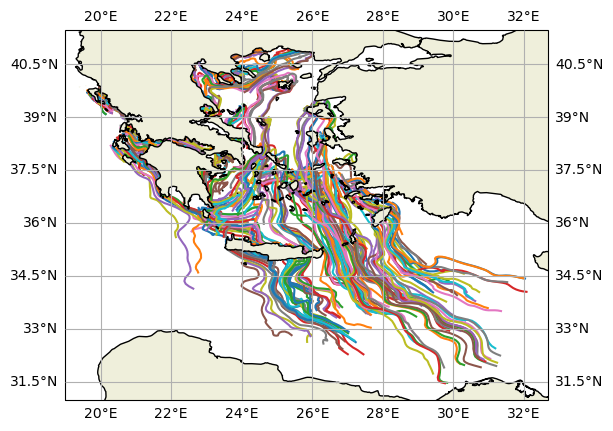

In [10]:
# Load the ParticleFile
ds = xr.open_zarr('example_Greece_coast.zarr')

# Plot the trajectories
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree(), zorder=0)
ax.add_feature(cfeature.LAND, zorder=1)
ax.coastlines(zorder=2)
ax.gridlines(draw_labels=True, zorder=3)
plt.show()